In [560]:
import pandas as pd
import numpy as np
import glob, os

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split

from fbprophet import Prophet
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import altair as alt
plt.style.use('seaborn-poster')
pd.plotting.register_matplotlib_converters()

In [493]:
simp_df = pd.read_csv('sc_m1.csv')
simp_df.Date = pd.to_datetime(simp_df.Date)
simp_df.set_index('Date', inplace=True)
simp_df.head()

,SC_M1
Date,
2015-11-23,195.0
2015-11-24,195.0
2015-11-25,195.0
2015-11-26,192.0
2015-11-27,192.0


In [494]:
mb_df = pd.read_excel('data/raw/MB.xls')
mb_df.Date = pd.to_datetime(mb_df.Date)
mb_df.set_index('Date', inplace=True)
mb_df.head()

,Low,High
Date,,
2019-07-01,292.09,292.09
2019-07-02,294.46,294.46
2019-07-03,291.88,291.88
2019-07-04,295.73,295.73
2019-07-05,296.18,296.18


In [495]:
simp_df['sc_mean'] = simp_df['SC_M1'].rolling(window=20, min_periods=1, center=True).mean()

In [496]:
future = simp_df.loc[(mb_df.index[0] <= simp_df.index) & (simp_df.index <= mb_df.index[-1])]
future = future.join(mb_df, on='Date')
future.head()

,SC_M1,sc_mean,Low,High
Date,,,,
2019-07-01,307.0,296.0265,292.09,292.09
2019-07-02,307.0,296.4265,294.46,294.46
2019-07-03,308.0,296.6265,291.88,291.88
2019-07-04,310.0,296.8765,295.73,295.73
2019-07-05,302.0,297.4015,296.18,296.18


In [497]:
(future.shape, mb_df.shape)

((216, 4), (253, 2))

In [498]:
future.isnull().sum()

SC_M1      0
sc_mean    0
Low        0
High       0
dtype: int64

In [499]:
#future.fillna(future.mean(), inplace=True)
future.dropna(inplace=True)
future.isnull().sum()

SC_M1      0
sc_mean    0
Low        0
High       0
dtype: int64

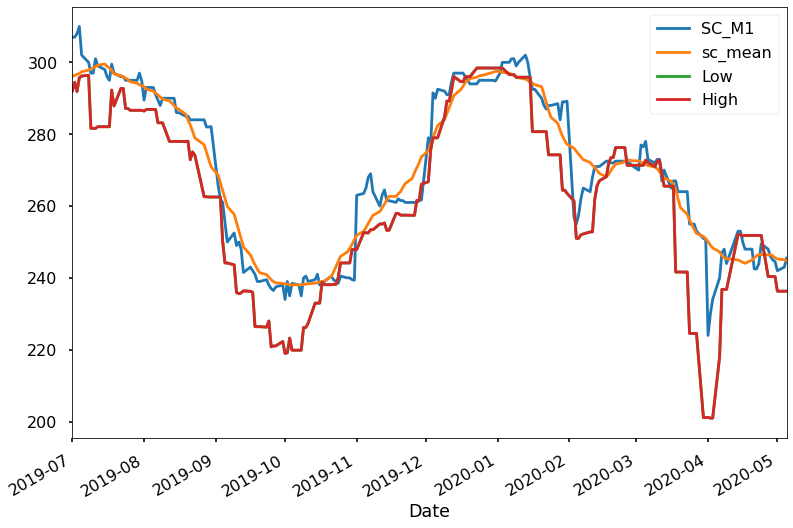

In [500]:
future.plot()

In [501]:
future['mb_mean'] = future[['High', 'Low']].mean(axis=1)

In [502]:
future.head()

,SC_M1,sc_mean,Low,High,mb_mean
Date,,,,,
2019-07-01,307.0,296.0265,292.09,292.09,292.09
2019-07-02,307.0,296.4265,294.46,294.46,294.46
2019-07-03,308.0,296.6265,291.88,291.88,291.88
2019-07-04,310.0,296.8765,295.73,295.73,295.73
2019-07-05,302.0,297.4015,296.18,296.18,296.18


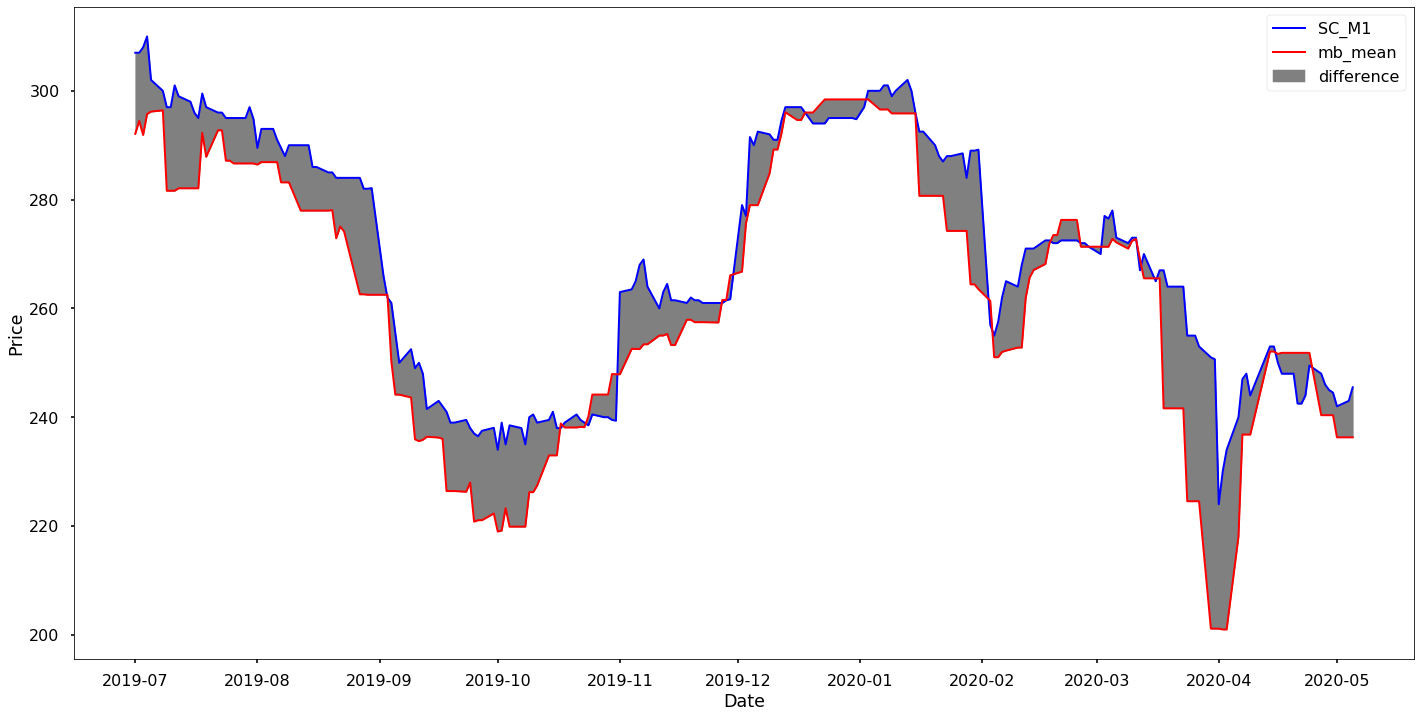

Desviación estándar media: SC_M1      22.278907
mb_mean    24.748448
dtype: float64
Diferencia media: 9.223981481481482
Diferencia máxima: 49.870000000000005
Diferencia mínima: 0.0


In [503]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot()
fig.patch.set_facecolor('w')

x_axis = future.index.values

ax.fill_between(x_axis, future['SC_M1'], future['mb_mean'], color='grey')
ax.plot(x_axis, future['SC_M1'], color='b', lw=2)
ax.plot(x_axis, future['mb_mean'], color='r', lw=2)


ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(['SC_M1', 'mb_mean', 'difference'])
plt.show()

print('Desviación estándar media:', future[['SC_M1', 'mb_mean']].std())
diff = abs(future['SC_M1'] - future['mb_mean'])
print('Diferencia media:', diff.mean())
print('Diferencia máxima:', diff.max())
print('Diferencia mínima:', diff.min())

## Observaciones:

El precio real (MB) y la predicción (SC) coinciden en forma. Sin embargo, SC suele ir un paso por detrás. Es decir, el precio real comienza a subir o bajar, y cierto tiempo después la predicción hace lo mismo. En ocasiones, el precio real se queda constante por un periodo de tiempo, pero la predicción sigue subiendo (o bajando), como con "inercia".
Esto se puede observar en `2019-11`, `2019-12.5` o `2020-02`.

En otras ocasiones parece que es la predicción quien cambia primero. La predicción empieza a caer, y un día (aprox) más tarde cae el precio real. Esto se da en una escala mucho más pequeña, y puede que sea solo coincidencia. Sin embargo, trae consigo la siguiente pregunta: 
> ¿El precio real se ve influenciado por la predicción, o simplemente la predicción es buena y está anticipando los movimientos del precio?

### Predicción influencia al precio
Estos datos de predicción están públicos en la web del LME, así que cualquiera puede verlos. Por eso, puede que si la predicción anticipase un cambio en el precio, los compradores lo viesen y decidiesen comprar/vender.
Esto habría que tenerlo en cuenta a la hora de hacer nosotros una predicción.
También habría que concretar cómo es esa influencia, ya que este fenómeno no se da siempre, o en la misma medida.

### Predicción es buena
¿Cómo de buena? Habría que medir cuánto falla (y sobre todo, cúando falla).

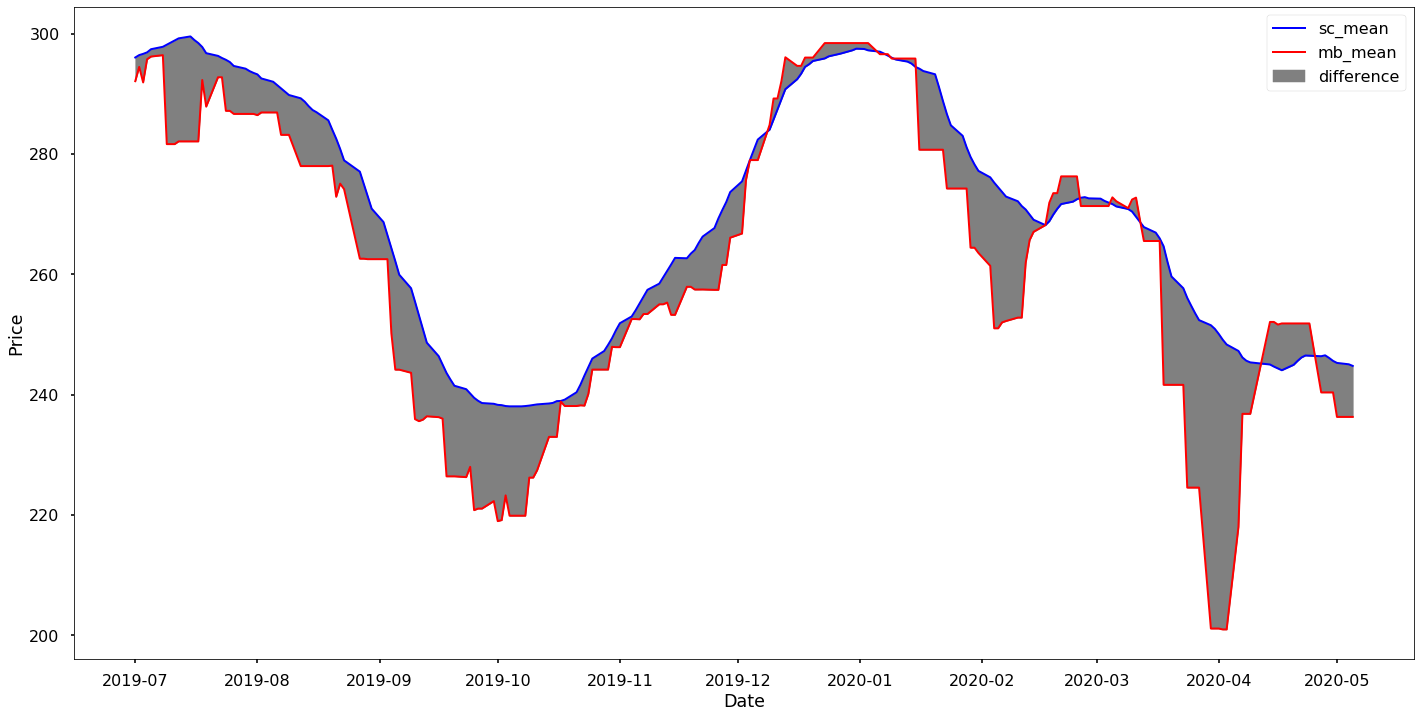

Desviación estándar media: sc_mean    20.312124
mb_mean    24.748448
dtype: float64
Diferencia media: 9.195190612296582
Diferencia máxima: 50.402499999999975
Diferencia mínima: 0.002999999999985903


In [504]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot()
fig.patch.set_facecolor('w')

x_axis = future.index.values

ax.fill_between(x_axis, future['sc_mean'], future['mb_mean'], color='grey')
ax.plot(x_axis, future['sc_mean'], color='b', lw=2)
ax.plot(x_axis, future['mb_mean'], color='r', lw=2)


ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(['sc_mean', 'mb_mean', 'difference'])
plt.show()

print('Desviación estándar media:', future[['sc_mean', 'mb_mean']].std())
diff = abs(future['sc_mean'] - future['mb_mean'])
print('Diferencia media:', diff.mean())
print('Diferencia máxima:', diff.max())
print('Diferencia mínima:', diff.min())

## Modelo ajustado

In [505]:
price_range = (257, 262)

In [506]:
def get_df_percent(dff, pc):
    new_range = (price_range[0] - price_range[0] * pc / 100, price_range[1] + price_range[1] * pc / 100)
    return dff.loc[(dff['SC_M1'] > new_range[0]) & (dff['SC_M1'] < new_range[1])], new_range

In [699]:
def add_caps(d1, d2=None, c='y'):
    if d2 is None:
        d2 = d1
    d2['cap'] = d1[c].max()
    d2['floor'] = d1[c].min()
    return d2

def prep(dff):
    dff = dff.copy()
    
    dff['day'] = (dff.index - dff.index[0]).days
    
    dff.reset_index(inplace=True)
    dff.rename({'Date': 'ds', 'SC_M1': 'y'}, axis=1, inplace=True)
    #dff.set_index(dff.ds, inplace=True)
    
    #dff = add_caps(dff)

    return dff

def get_features(dff):
    return dff[['day']], dff[['y']]
    
def plot_df(df, d_col='ds', y_col='y'):
    df = df.copy()
    if d_col in df.columns:
        df.set_index(d_col, inplace=True)
    to_drop = [c for c in df.columns if c not in [d_col, y_col]]
    df.drop(to_drop, inplace=True, axis=1)
    x = plt.plot(df, "b.")
    xlabel("Date")
    ylabel("Price")
    return x

In [700]:
percents = [2, 5, 10, 15, 20, 35]

In [701]:
p = 'sc_m1.csv'
comp_df = pd.read_csv(p, usecols=['Date', 'SC_M1'])
comp_df['Date'] = pd.to_datetime(comp_df['Date'])
comp_df.set_index('Date', inplace=True)

In [702]:
models = {}
dfs = []
for p in percents:
    df, r = get_df_percent(comp_df, p)
    df = prep(df)
    dfs.append((p, r, df))
    
    X, y = get_features(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train['y'].ravel())
    
    
    
    # Prophet
    # train, X_test = train_test_split(df)

    #model = Prophet(growth='linear', seasonality_mode='additive', yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)
    #model.fit(train)
    
    preds = model.predict(X_test)
    # prophet: X_test, y_test = get_features(test)
    acc = r2_score(preds, y_test['y']) * 100
    th = (preds - y_test['y'])

    err = np.nanmean(np.absolute(preds - y_test['y']))
    
    s = 'Model_{}'.format(p)
    models[s] = (model, df, acc, err)
    # model.fit(X_train, y_train)
    # model.predict(X_test, y_test)
    # plot and save results to list
    print(s + '\nR Score: {:.2f}%'.format(acc))
    print("Mean absolute error: {:.2f}".format(err))

Model_2
R Score: 37.15%
Mean absolute error: 1.50
Model_5
R Score: 75.21%
Mean absolute error: 1.87
Model_10
R Score: 94.37%
Mean absolute error: 2.11
Model_15
R Score: 98.46%
Mean absolute error: 1.90
Model_20
R Score: 96.78%
Mean absolute error: 2.52
Model_35
R Score: 99.26%
Mean absolute error: 2.48


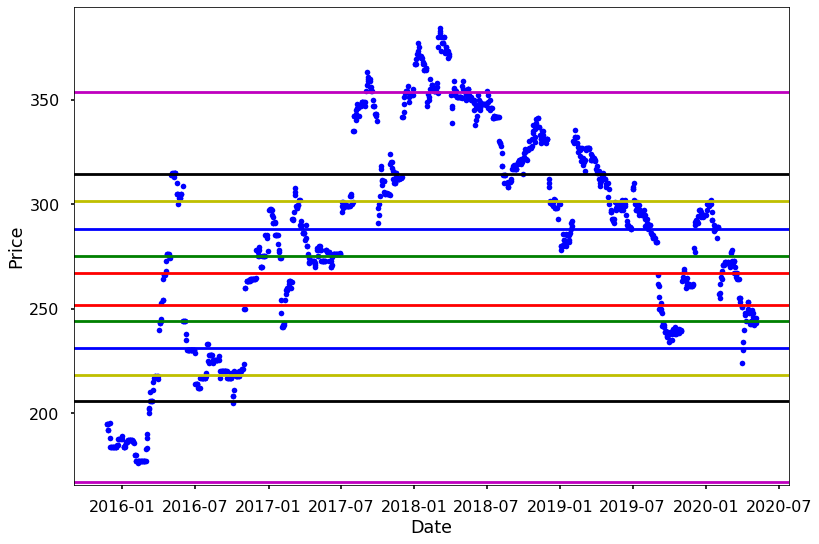

In [703]:
plot_df(comp_df, 'Date', 'SC_M1')
colors = 'r,g,b,y,k,m'.split(',')
c = 0
for d in dfs:
    max_price = max(d[1])
    min_price = min(d[1])
    plt.axhline(y=max_price, color=colors[c], linestyle='-')
    plt.axhline(y=min_price, color=colors[c], linestyle='-')
    c += 1
plt.show()

Model_2%


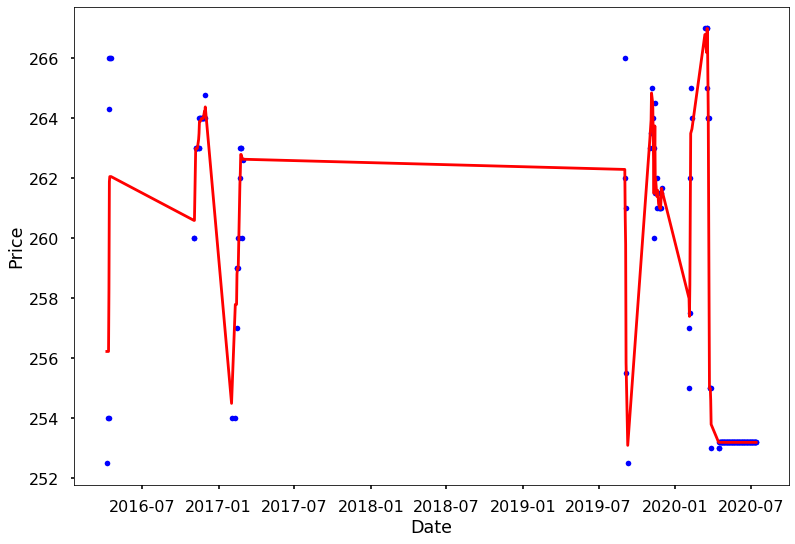

R Score: 37.15%
Mean absolute error: 1.50

Model_5%


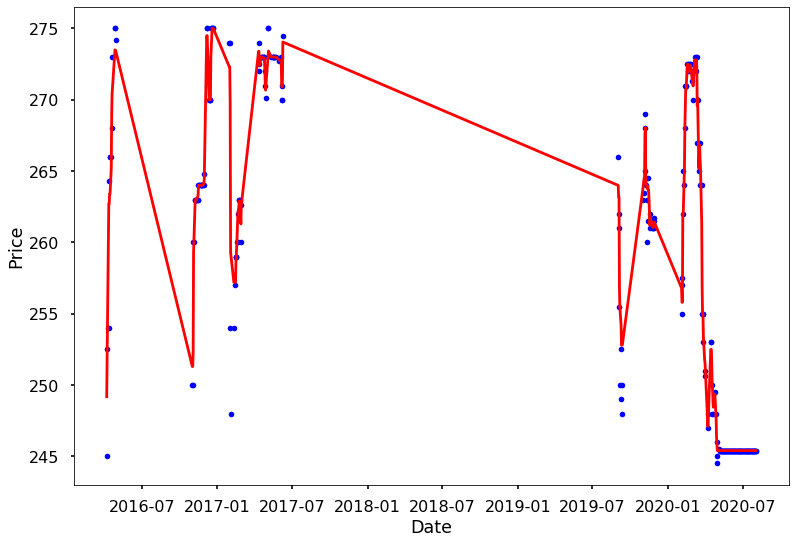

R Score: 75.21%
Mean absolute error: 1.87

Model_10%


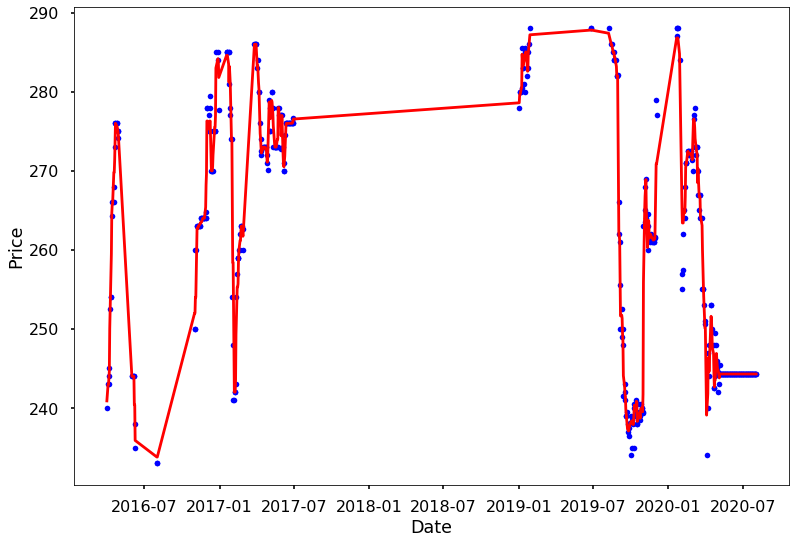

R Score: 94.37%
Mean absolute error: 2.11

Model_15%


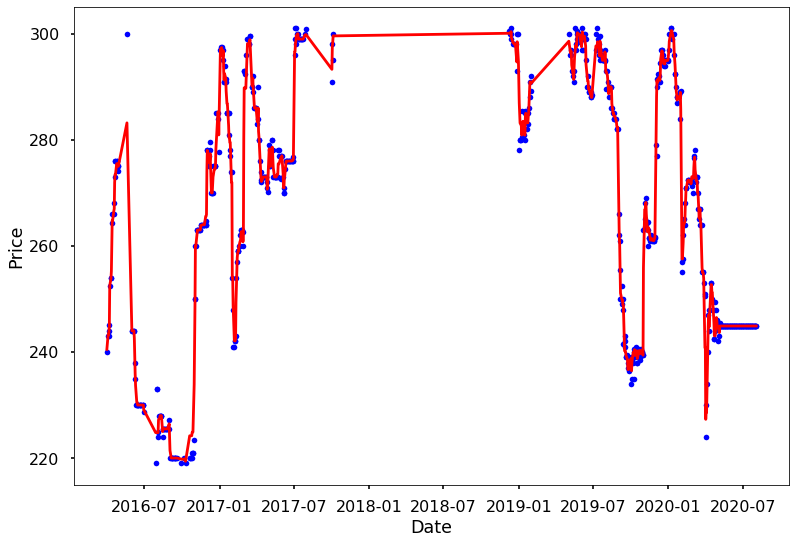

R Score: 98.46%
Mean absolute error: 1.90

Model_20%


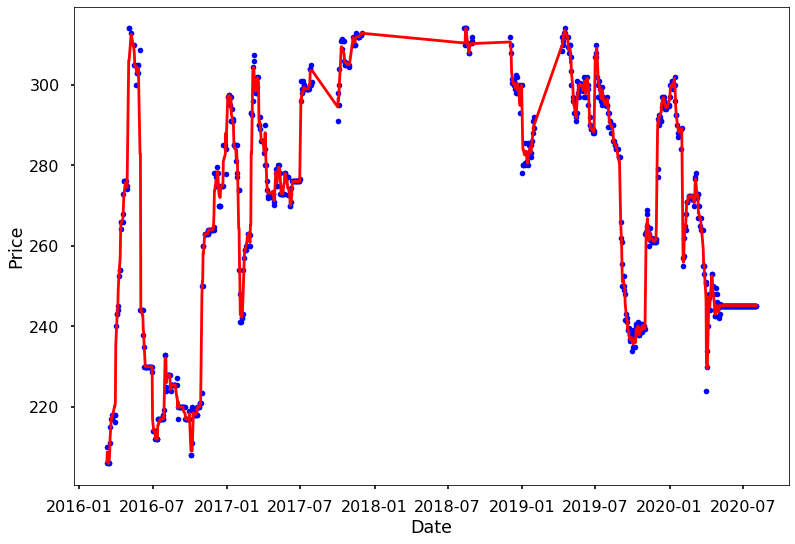

R Score: 96.78%
Mean absolute error: 2.52

Model_35%


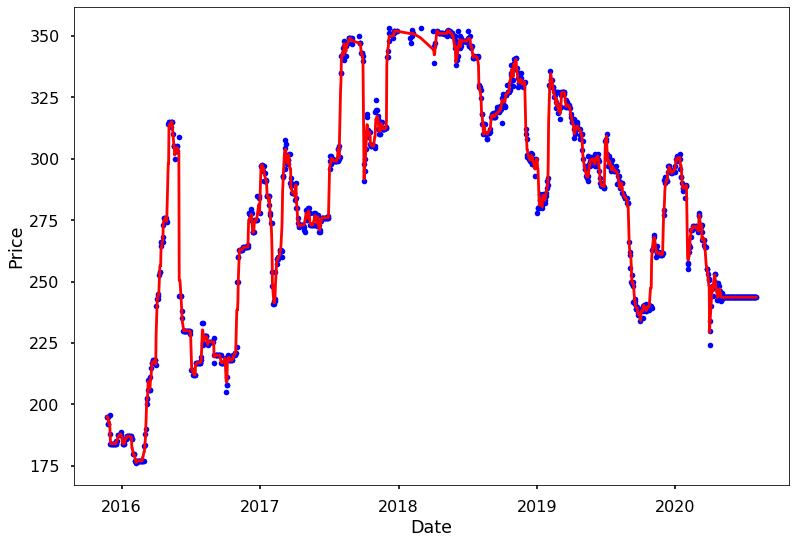

R Score: 99.26%
Mean absolute error: 2.48



In [715]:
c = 0
for k, (m, df, acc, err) in models.items():
    print(k + '%')
    # fut = m.make_future_dataframe(periods=90, freq='d', include_history=False)
    df = df.copy()
    
    dt_rn = pd.date_range(start=df.ds.iloc[-1], periods=90, freq='d', closed='right')
    days = (dt_rn - df.ds.iloc[0]).days

    fut = pd.DataFrame({'ds': dt_rn, 'day': days, 'y': np.NaN})
    
    forecast = m.predict(fut[['day']])
    
    fut['y'] = forecast
    
    all_df = pd.concat([df, fut], sort=False)
    all_df['ds'] = pd.to_datetime(all_df['ds'])
    fig = plot_df(all_df)
    
    all_df.set_index('ds', inplace=True)
    to_drop = [c for c in all_df.columns if c not in ['ds', 'y']]
    pred = m.predict(all_df[['day']])
    all_df.drop(to_drop, inplace=True, axis=1)
        
    plot(all_df.index, pred, '-r')
    xlabel("Date")
    ylabel("Price")
    plt.show()
    print('R Score: {:.2f}%'.format(acc))
    print("Mean absolute error: {:.2f}".format(err))
    print('')
    c += 1